## Boundary layer properties across heterogeneous landscapes - BLIMP

#### Team Members: 
#### Tim Juliano, Joe O’Brien, Tim Wagner
#### Ajmal Rasheeda Satheesh, Garett Warner, Jiaxuan Cai

In [1]:
import xarray as xr
import numpy as np
import os
import act
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.spatial import cKDTree
import pandas as pd
from wrf import (getvar, CoordPair, vertcross, latlon_coords, to_np, destagger)
import glob
import netCDF4 as nc
import matplotlib as mpl

mpl.rcParams['font.size'] = 14  
plt.rcParams.update({
    "font.size": 14,           
    "axes.titlesize": 16,      
    "axes.labelsize": 14,      
    "xtick.labelsize": 14,     
    "ytick.labelsize": 14,     
    "legend.fontsize": 14,     
    "figure.titlesize": 14     
})

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


## Sites

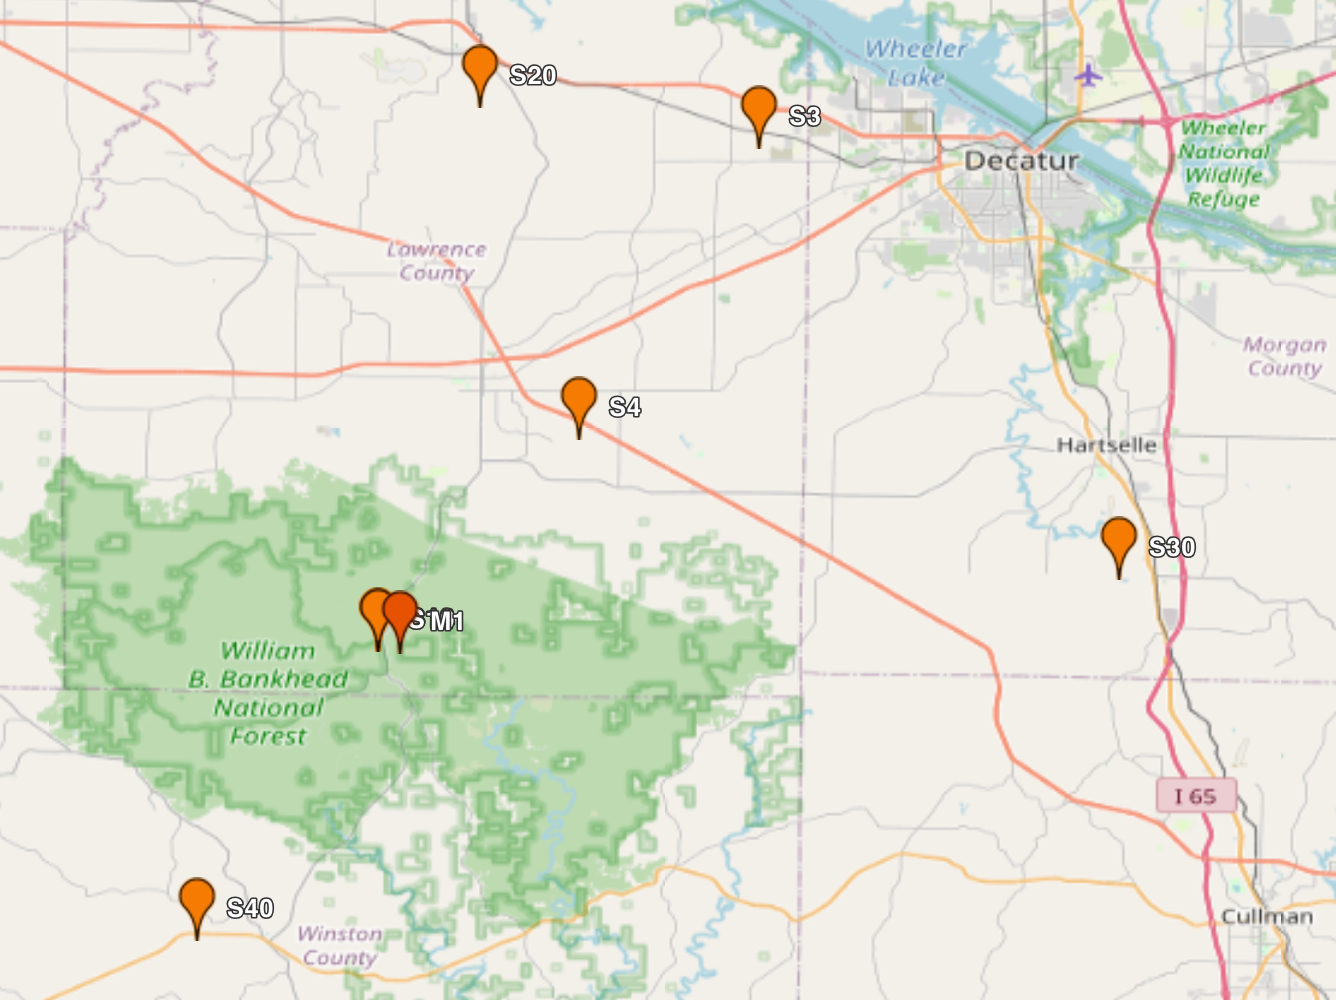

In [2]:
from IPython.display import HTML

HTML("""
<div style="display: flex; justify-content: center; align-items: flex-start; gap: 20px;">
    <div style="text-align: center;">
        <img src="images/S20.png" width="300"><br>
        <span style="font-size:18px;">S20</span>
    </div>
    <div style="text-align: center;">
        <img src="images/S30.png" width="300"><br>
        <span style="font-size:18px;">S30</span>
    </div>
    <div style="text-align: center;">
        <img src="images/S40.png" width="300"><br>
        <span style="font-size:18px;">S40</span>
    </div>
</div>
""")

### PBL Height

In [3]:
sonde_times = pd.to_datetime([
    '2025-04-04 11:30',
    '2025-04-04 17:30',
    '2025-04-04 23:30'])

data1 = [661.7, 1685.1, 1710.7]
data2 = [2241.8, 2201.9, 4037.9]

sonde_ds = xr.Dataset({
    'liu_liang': ('time', data1),
    'heffter': ('time', data2)
}, coords={'time': sonde_times})

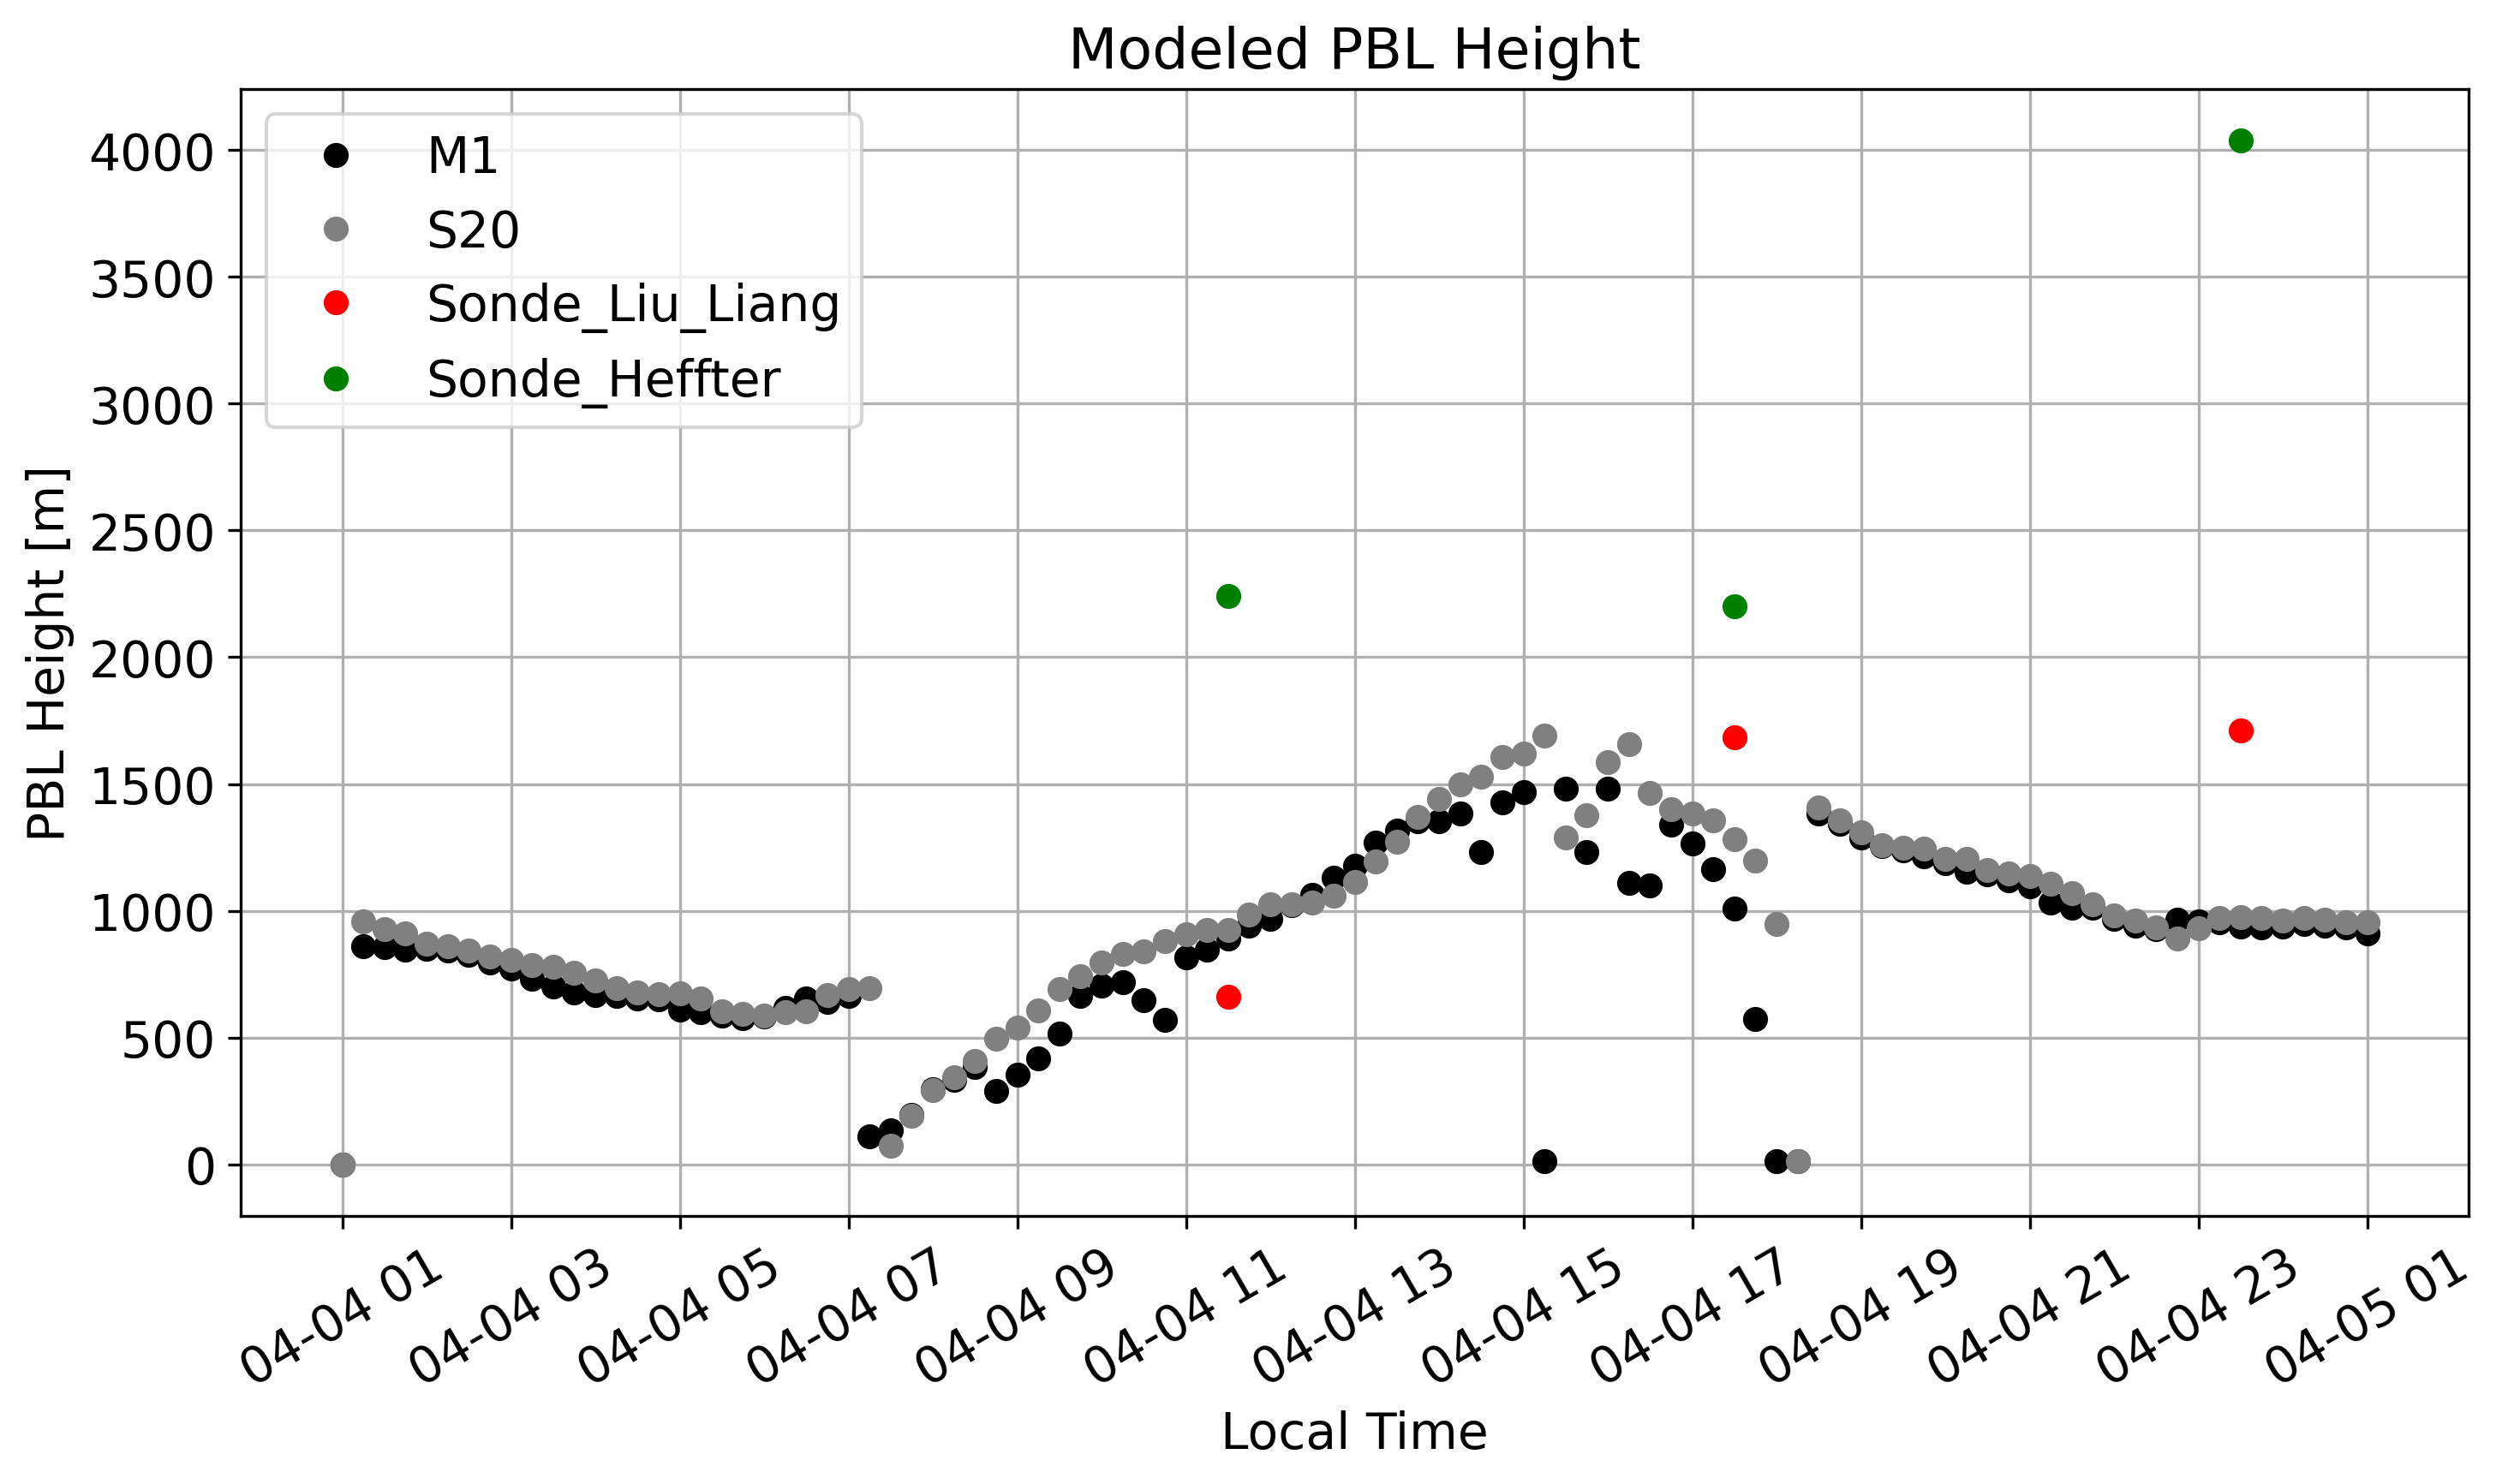

In [4]:
## Apr 4
# Set paths to model outputs
path_head = '/data/project/ARM_Summer_School_2025/model/wrf/'
case_days = ['2025040406/'] #15min; 10min 
for case_day in case_days:
    ds_wrf = xr.open_mfdataset(os.path.join(path_head+case_day+'run/wrfout_d01*'),concat_dim='Time',combine='nested')
    # ds_wrf
    # Create a dictionary for our ARM sites so we can easily find them in the model
    # Pull static lat/lon at first time step
    lat2d = ds_wrf['XLAT'].isel(Time=0)
    lon2d = ds_wrf['XLONG'].isel(Time=0)
    # Flatten and build KDTree
    flat_coords = np.column_stack((lat2d.values.ravel(), lon2d.values.ravel()))
    tree = cKDTree(flat_coords)
    # ARM site locations
    target_lat = [34.3425, 34.6538, 34.3848, 34.1788]
    target_lon = [-87.3382, -87.2927, -86.9279, -87.4539]
    target_coords = np.column_stack((target_lat, target_lon))
    # Find nearest indices
    _, flat_idx = tree.query(target_coords)
    i_indices, j_indices = np.unravel_index(flat_idx, lat2d.shape)
    # Create dict of site names to datasets
    site_names = ['M1', 'S20', 'S30', 'S40']
    site_datasets = {}
    for name, i, j in zip(site_names, i_indices, j_indices):
        site_datasets[name] = ds_wrf.isel(south_north=i, west_east=j).expand_dims(site=[name])
    # Subset the original WRF dataset so that it includes information for just our sites
    ds_wrf_bnf_site = xr.concat(site_datasets.values(), dim='site')
    ds_wrf_bnf_site

    var1 = ds_wrf_bnf_site['PBLH']
    var1a = ds_wrf_bnf_site['HFX'] # surface sensible heat flux
    var1b = ds_wrf_bnf_site['LH'] # surface latent heat flux
    var1c = ds_wrf_bnf_site['LWP'] # liquid water path
    LU_INDEX  = ds_wrf_bnf_site['LU_INDEX']
    VEGFRA = ds_wrf_bnf_site['VEGFRA']
    PCT_PFT = ds_wrf_bnf_site['PCT_PFT']
    LAI = ds_wrf_bnf_site['LAI']
    EMISS = ds_wrf_bnf_site['EMISS']
    ALBEDO = ds_wrf_bnf_site['ALBEDO']
    SMOIS = ds_wrf_bnf_site['SMOIS']
    RAINC = ds_wrf_bnf_site['RAINC']
    RAINNC = ds_wrf_bnf_site['RAINNC']
    xtime = pd.to_datetime(var1['XTIME'].values) - pd.Timedelta(hours=5)

    # Make the plot
    plt.figure(figsize=(10, 6),dpi=300)
    cols = ['k','gray','b','lightskyblue']
    ######################## Subplot 1 ########################
    # Sensible and latent heat fluxes
    count = 0
    for site in ['M1', 'S20']:
        plt.plot(xtime, var1.sel(site=site), c=cols[count], marker='o', linestyle='none',label=site)
        count+=1
    plt.plot(sonde_ds['time'], sonde_ds['liu_liang'], c='r', marker='o', linestyle='none',label='Sonde_Liu_Liang')
    plt.plot(sonde_ds['time'], sonde_ds['heffter'], c='green', marker='o', linestyle='none',label='Sonde_Heffter')
    plt.xticks(rotation=30)
    plt.xlabel("Local Time")
    plt.ylabel("PBL Height [m]")
    plt.title("Modeled PBL Height")
    plt.legend()
    plt.grid(True)
    #plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=2))
    #plt.gcf().autofmt_xdate() # clean up labels
    plt.tight_layout()
    plt.show()

In [5]:
sonde_times = pd.to_datetime([
    '2025-04-11 05:30',
    '2025-04-11 11:30',
    '2025-04-11 17:30',
    '2025-04-11 23:30'])

data1 = [742.69995117,516.20001221,3568,466.4]
data2 = [306.1, 306.1,3568,379.2]

sonde_ds = xr.Dataset({
    'liu_liang': ('time', data1),
    'heffter': ('time', data2)
}, coords={'time': sonde_times})

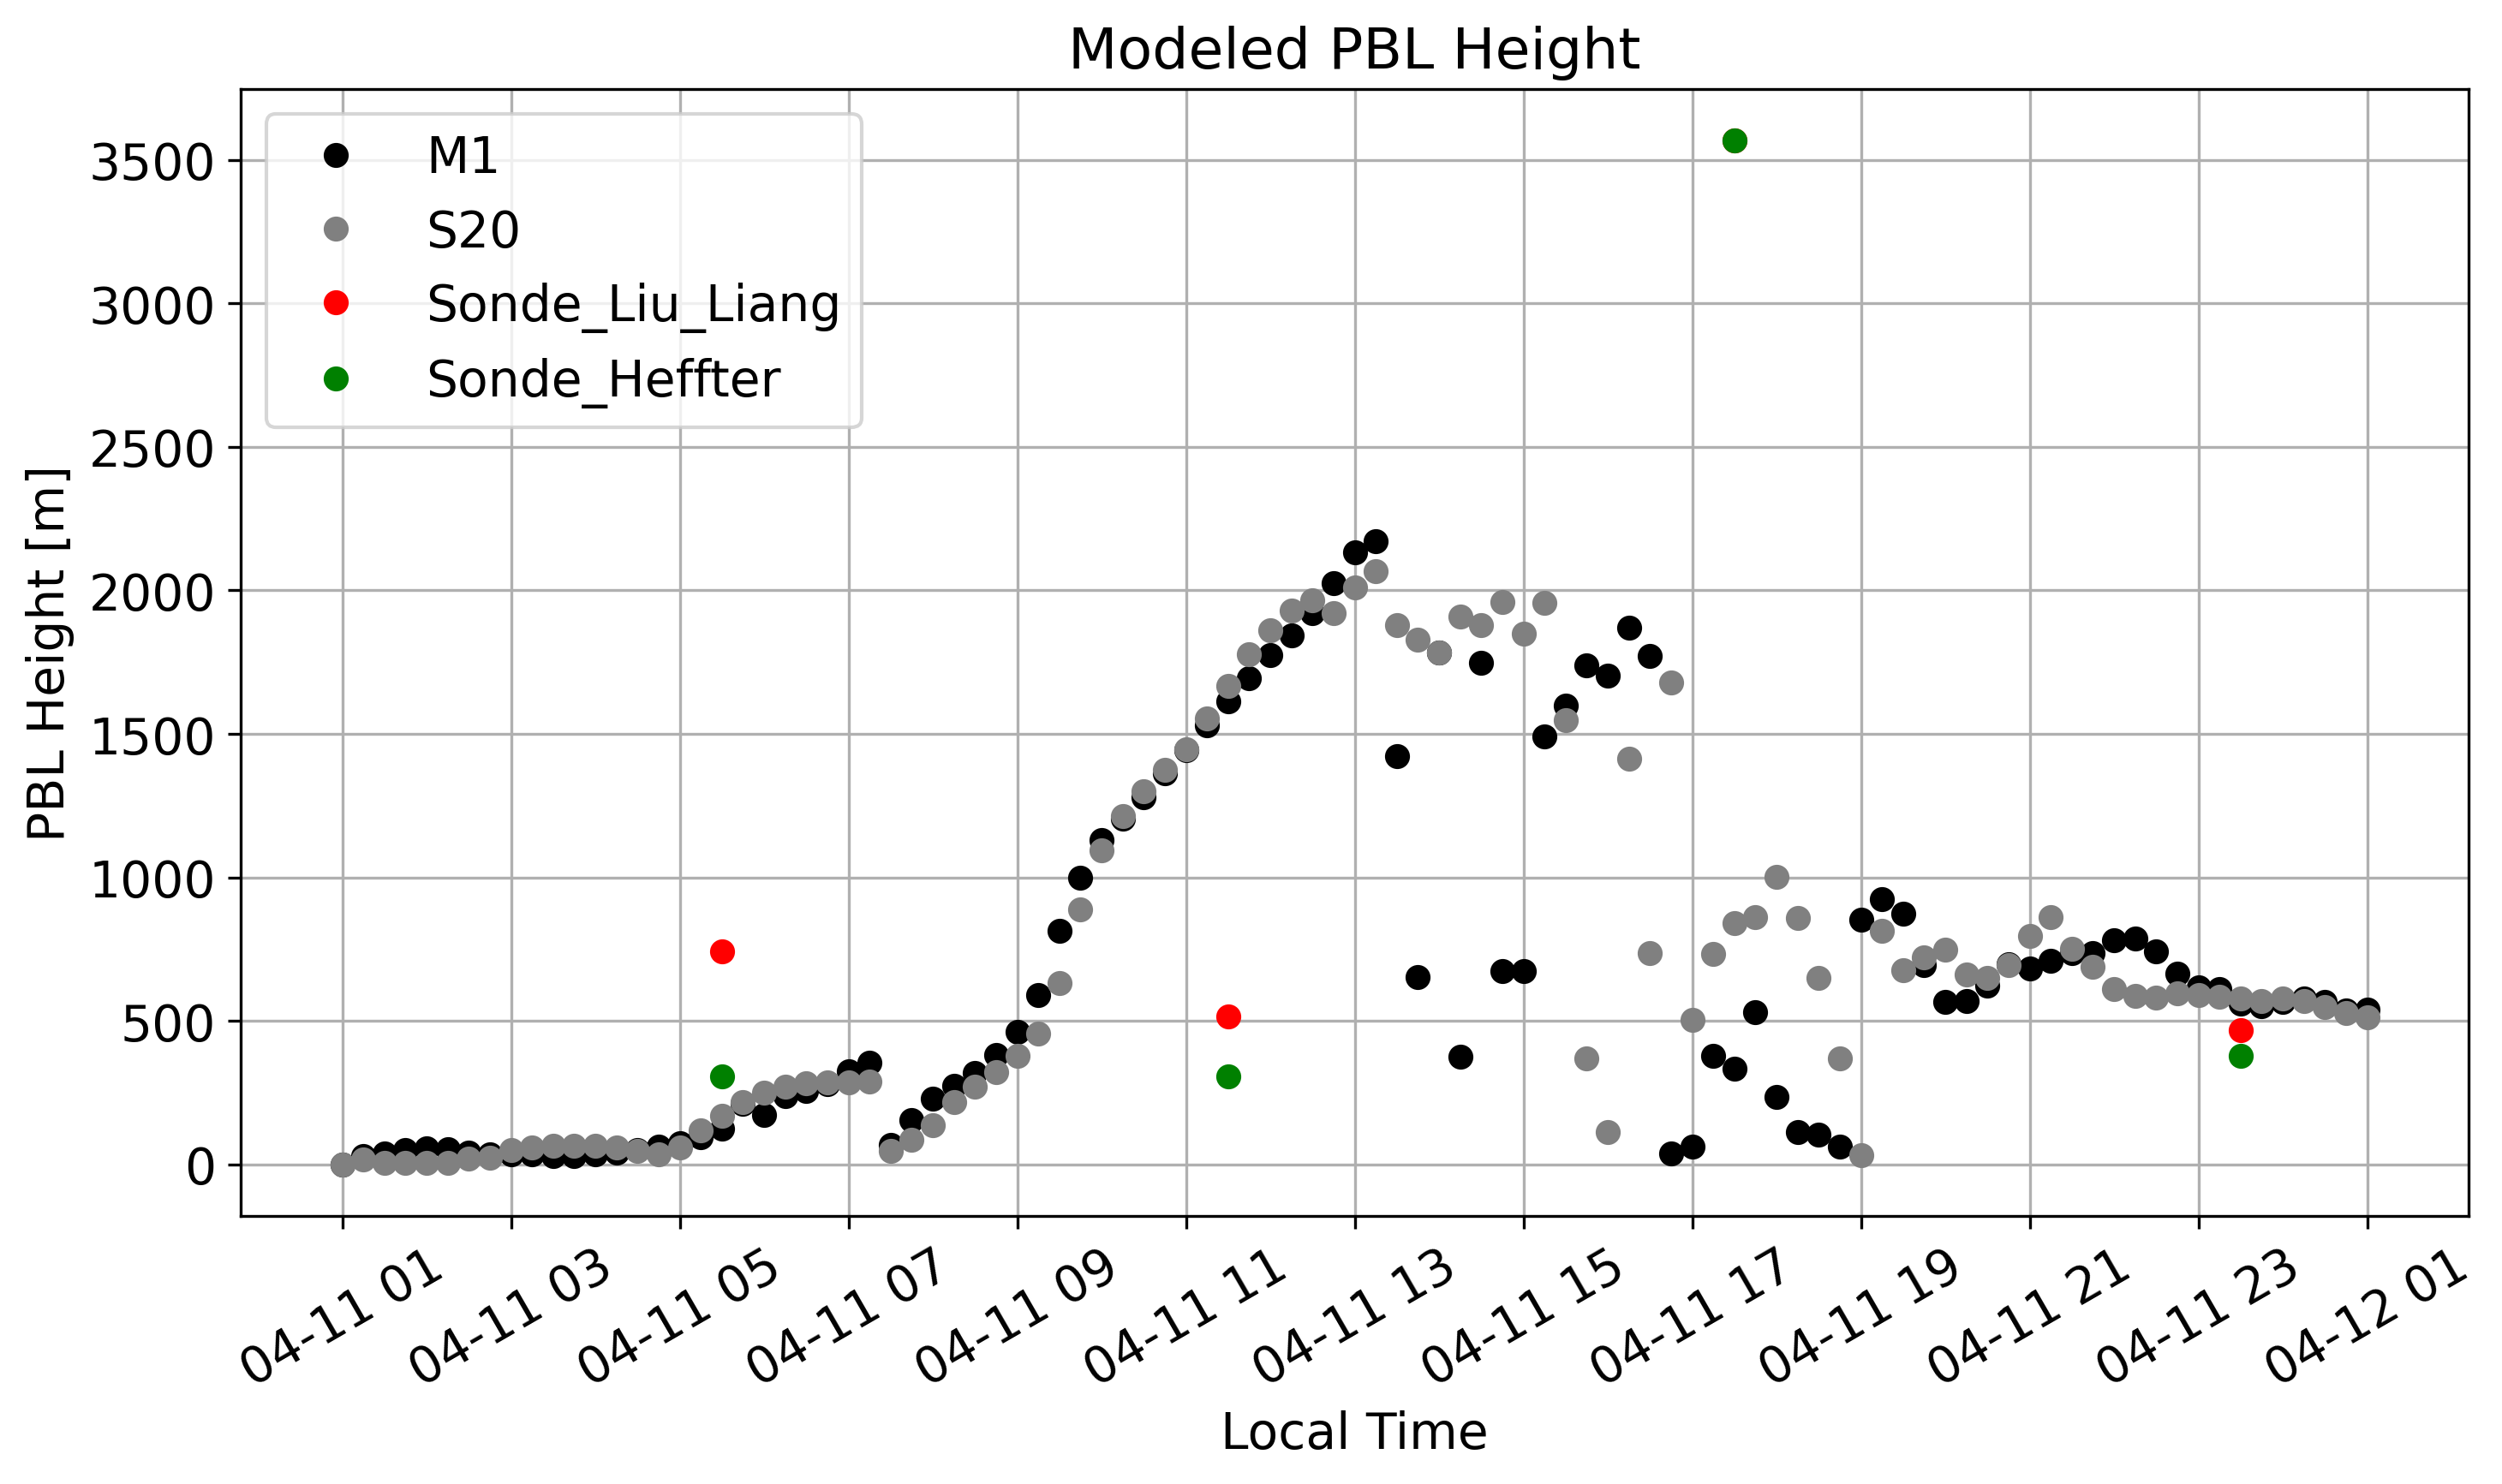

In [6]:
## Apr 4
# Set paths to model outputs
path_head = '/data/project/ARM_Summer_School_2025/model/wrf/'
case_days = ['2025041106/'] #15min; 10min 
for case_day in case_days:
    ds_wrf = xr.open_mfdataset(os.path.join(path_head+case_day+'run/wrfout_d01*'),concat_dim='Time',combine='nested')
    # ds_wrf
    # Create a dictionary for our ARM sites so we can easily find them in the model
    # Pull static lat/lon at first time step
    lat2d = ds_wrf['XLAT'].isel(Time=0)
    lon2d = ds_wrf['XLONG'].isel(Time=0)
    # Flatten and build KDTree
    flat_coords = np.column_stack((lat2d.values.ravel(), lon2d.values.ravel()))
    tree = cKDTree(flat_coords)
    # ARM site locations
    target_lat = [34.3425, 34.6538, 34.3848, 34.1788]
    target_lon = [-87.3382, -87.2927, -86.9279, -87.4539]
    target_coords = np.column_stack((target_lat, target_lon))
    # Find nearest indices
    _, flat_idx = tree.query(target_coords)
    i_indices, j_indices = np.unravel_index(flat_idx, lat2d.shape)
    # Create dict of site names to datasets
    site_names = ['M1', 'S20', 'S30', 'S40']
    site_datasets = {}
    for name, i, j in zip(site_names, i_indices, j_indices):
        site_datasets[name] = ds_wrf.isel(south_north=i, west_east=j).expand_dims(site=[name])
    # Subset the original WRF dataset so that it includes information for just our sites
    ds_wrf_bnf_site = xr.concat(site_datasets.values(), dim='site')
    ds_wrf_bnf_site

    var1 = ds_wrf_bnf_site['PBLH']
    var1a = ds_wrf_bnf_site['HFX'] # surface sensible heat flux
    var1b = ds_wrf_bnf_site['LH'] # surface latent heat flux
    var1c = ds_wrf_bnf_site['LWP'] # liquid water path
    LU_INDEX  = ds_wrf_bnf_site['LU_INDEX']
    VEGFRA = ds_wrf_bnf_site['VEGFRA']
    PCT_PFT = ds_wrf_bnf_site['PCT_PFT']
    LAI = ds_wrf_bnf_site['LAI']
    EMISS = ds_wrf_bnf_site['EMISS']
    ALBEDO = ds_wrf_bnf_site['ALBEDO']
    SMOIS = ds_wrf_bnf_site['SMOIS']
    RAINC = ds_wrf_bnf_site['RAINC']
    RAINNC = ds_wrf_bnf_site['RAINNC']
    xtime = pd.to_datetime(var1['XTIME'].values) - pd.Timedelta(hours=5)

    # Make the plot
    plt.figure(figsize=(10, 6),dpi=300)
    cols = ['k','gray','b','lightskyblue']
    ######################## Subplot 1 ########################
    # Sensible and latent heat fluxes
    count = 0
    for site in ['M1', 'S20']:
        plt.plot(xtime, var1.sel(site=site), c=cols[count], marker='o', linestyle='none',label=site)
        count+=1
    plt.plot(sonde_ds['time'], sonde_ds['liu_liang'], c='r', marker='o', linestyle='none',label='Sonde_Liu_Liang')
    plt.plot(sonde_ds['time'], sonde_ds['heffter'], c='green', marker='o', linestyle='none',label='Sonde_Heffter')
    plt.xticks(rotation=30)
    plt.xlabel("Local Time")
    plt.ylabel("PBL Height [m]")
    plt.title("Modeled PBL Height")
    plt.legend()
    plt.grid(True)
    #plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=2))
    #plt.gcf().autofmt_xdate() # clean up labels
    plt.tight_layout()
    plt.show()

### WRF

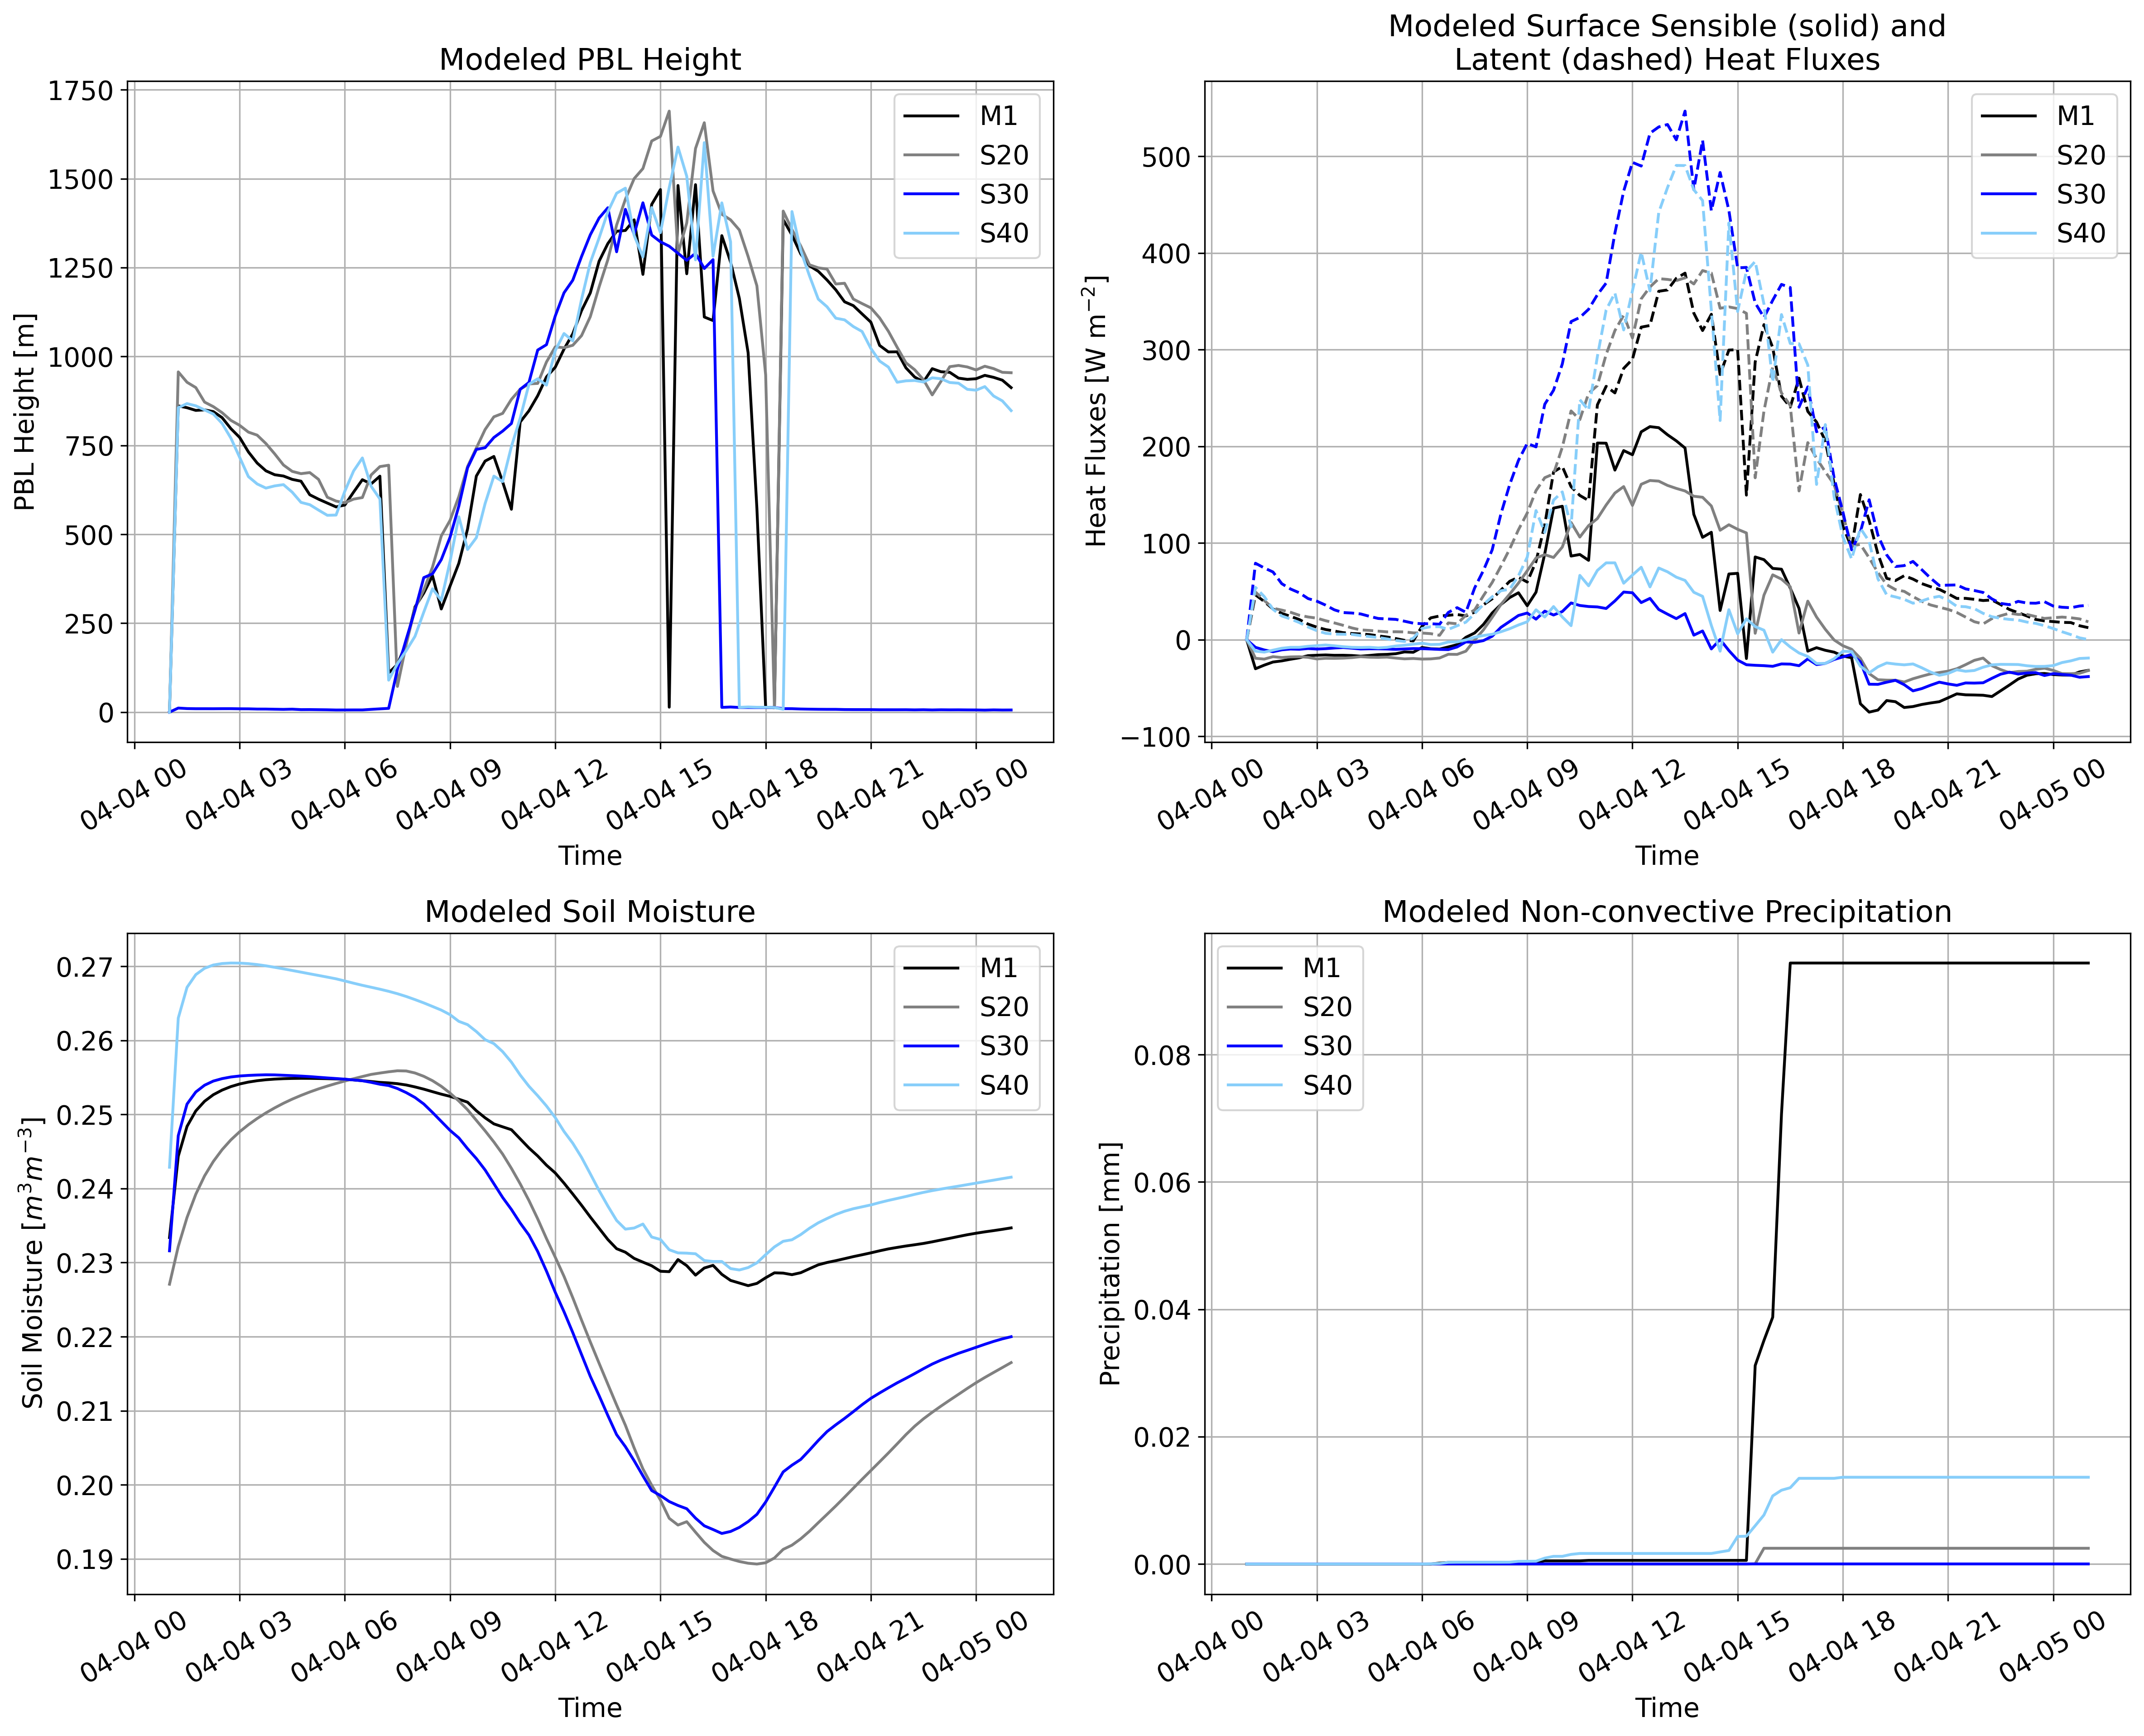

In [7]:
# Set paths to model outputs
path_head = '/data/project/ARM_Summer_School_2025/model/wrf/'
case_days = ['2025040406/'] #15min; 10min 
for case_day in case_days:
    ds_wrf = xr.open_mfdataset(os.path.join(path_head+case_day+'run/wrfout_d01*'),concat_dim='Time',combine='nested')
    # ds_wrf
    # Create a dictionary for our ARM sites so we can easily find them in the model
    # Pull static lat/lon at first time step
    lat2d = ds_wrf['XLAT'].isel(Time=0)
    lon2d = ds_wrf['XLONG'].isel(Time=0)
    # Flatten and build KDTree
    flat_coords = np.column_stack((lat2d.values.ravel(), lon2d.values.ravel()))
    tree = cKDTree(flat_coords)
    # ARM site locations
    target_lat = [34.3425, 34.6538, 34.3848, 34.1788]
    target_lon = [-87.3382, -87.2927, -86.9279, -87.4539]
    target_coords = np.column_stack((target_lat, target_lon))
    # Find nearest indices
    _, flat_idx = tree.query(target_coords)
    i_indices, j_indices = np.unravel_index(flat_idx, lat2d.shape)
    # Create dict of site names to datasets
    site_names = ['M1', 'S20', 'S30', 'S40']
    site_datasets = {}
    for name, i, j in zip(site_names, i_indices, j_indices):
        site_datasets[name] = ds_wrf.isel(south_north=i, west_east=j).expand_dims(site=[name])
    # Subset the original WRF dataset so that it includes information for just our sites
    ds_wrf_bnf_site = xr.concat(site_datasets.values(), dim='site')
    ds_wrf_bnf_site

    var1 = ds_wrf_bnf_site['PBLH']
    var1a = ds_wrf_bnf_site['HFX'] # surface sensible heat flux
    var1b = ds_wrf_bnf_site['LH'] # surface latent heat flux
    var1c = ds_wrf_bnf_site['LWP'] # liquid water path
    LU_INDEX  = ds_wrf_bnf_site['LU_INDEX']
    VEGFRA = ds_wrf_bnf_site['VEGFRA']
    PCT_PFT = ds_wrf_bnf_site['PCT_PFT']
    LAI = ds_wrf_bnf_site['LAI']
    EMISS = ds_wrf_bnf_site['EMISS']
    ALBEDO = ds_wrf_bnf_site['ALBEDO']
    SMOIS = ds_wrf_bnf_site['SMOIS']
    RAINC = ds_wrf_bnf_site['RAINC']
    RAINNC = ds_wrf_bnf_site['RAINNC']
    xtime = pd.to_datetime(var1['XTIME'].values) - pd.Timedelta(hours=5)

    # Make the plot
    plt.figure(figsize=(16, 13),dpi=300)
    cols = ['k','gray','b','lightskyblue']
    ######################## Subplot 1 ########################
    # Sensible and latent heat fluxes
    plt.subplot(2,2,1)
    count = 0
    for site in var1.site.values:
        plt.plot(xtime, var1.sel(site=site), c=cols[count], label=site)
        count+=1
    plt.xticks(rotation=30)
    plt.xlabel("Time")
    plt.ylabel("PBL Height [m]")
    plt.title("Modeled PBL Height")
    plt.legend()
    plt.grid(True)
    #plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    #plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=2))
    ######################## Subplot 2 ########################
    plt.subplot(2,2,2)
    count = 0
    for site in var1a.site.values:
        plt.plot(xtime, var1a.sel(site=site), c=cols[count], label=site)
        plt.plot(xtime, var1b.sel(site=site), c=cols[count], ls='--')
        count+=1
    plt.xticks(rotation=30)
    plt.xlabel("Time")
    plt.ylabel("Heat Fluxes [W m$^{-2}$]")
    plt.title("Modeled Surface Sensible (solid) and\nLatent (dashed) Heat Fluxes")
    plt.legend()
    plt.grid(True)
    ######################## Subplot 3 ########################
    # Sensible and latent heat fluxes
    plt.subplot(2,2,3)
    count = 0
    for site in var1.site.values:
        plt.plot(xtime, SMOIS.sel(site=site)[:,0], c=cols[count], label=site)
        count+=1
    plt.xticks(rotation=30)
    plt.xlabel("Time")
    plt.ylabel("Soil Moisture [$m^3 m^{-3}$]")
    plt.title("Modeled Soil Moisture")
    plt.legend()
    plt.grid(True)

    # Liquid water path
    plt.subplot(2,2,4)
    count = 0
    for site in var1.site.values:
        #plt.plot(var2['XTIME'], var2.sel(site=site), c=cols[count], label=site)
        plt.plot(xtime, RAINNC.sel(site=site), c=cols[count], label=site)
        count+=1
    plt.xticks(rotation=30)
    plt.xlabel("Time")
    #plt.ylabel("Liquid Water Path [kg m$^{-2}$]")
    #plt.title("Modeled Liquid Water Path (solid) at ARM Sites")
    plt.ylabel("Precipitation [mm]")
    plt.title("Modeled Non-convective Precipitation")
    plt.legend()
    plt.grid(True)
    #plt.gcf().autofmt_xdate() # clean up labels
    plt.tight_layout()
    plt.show()

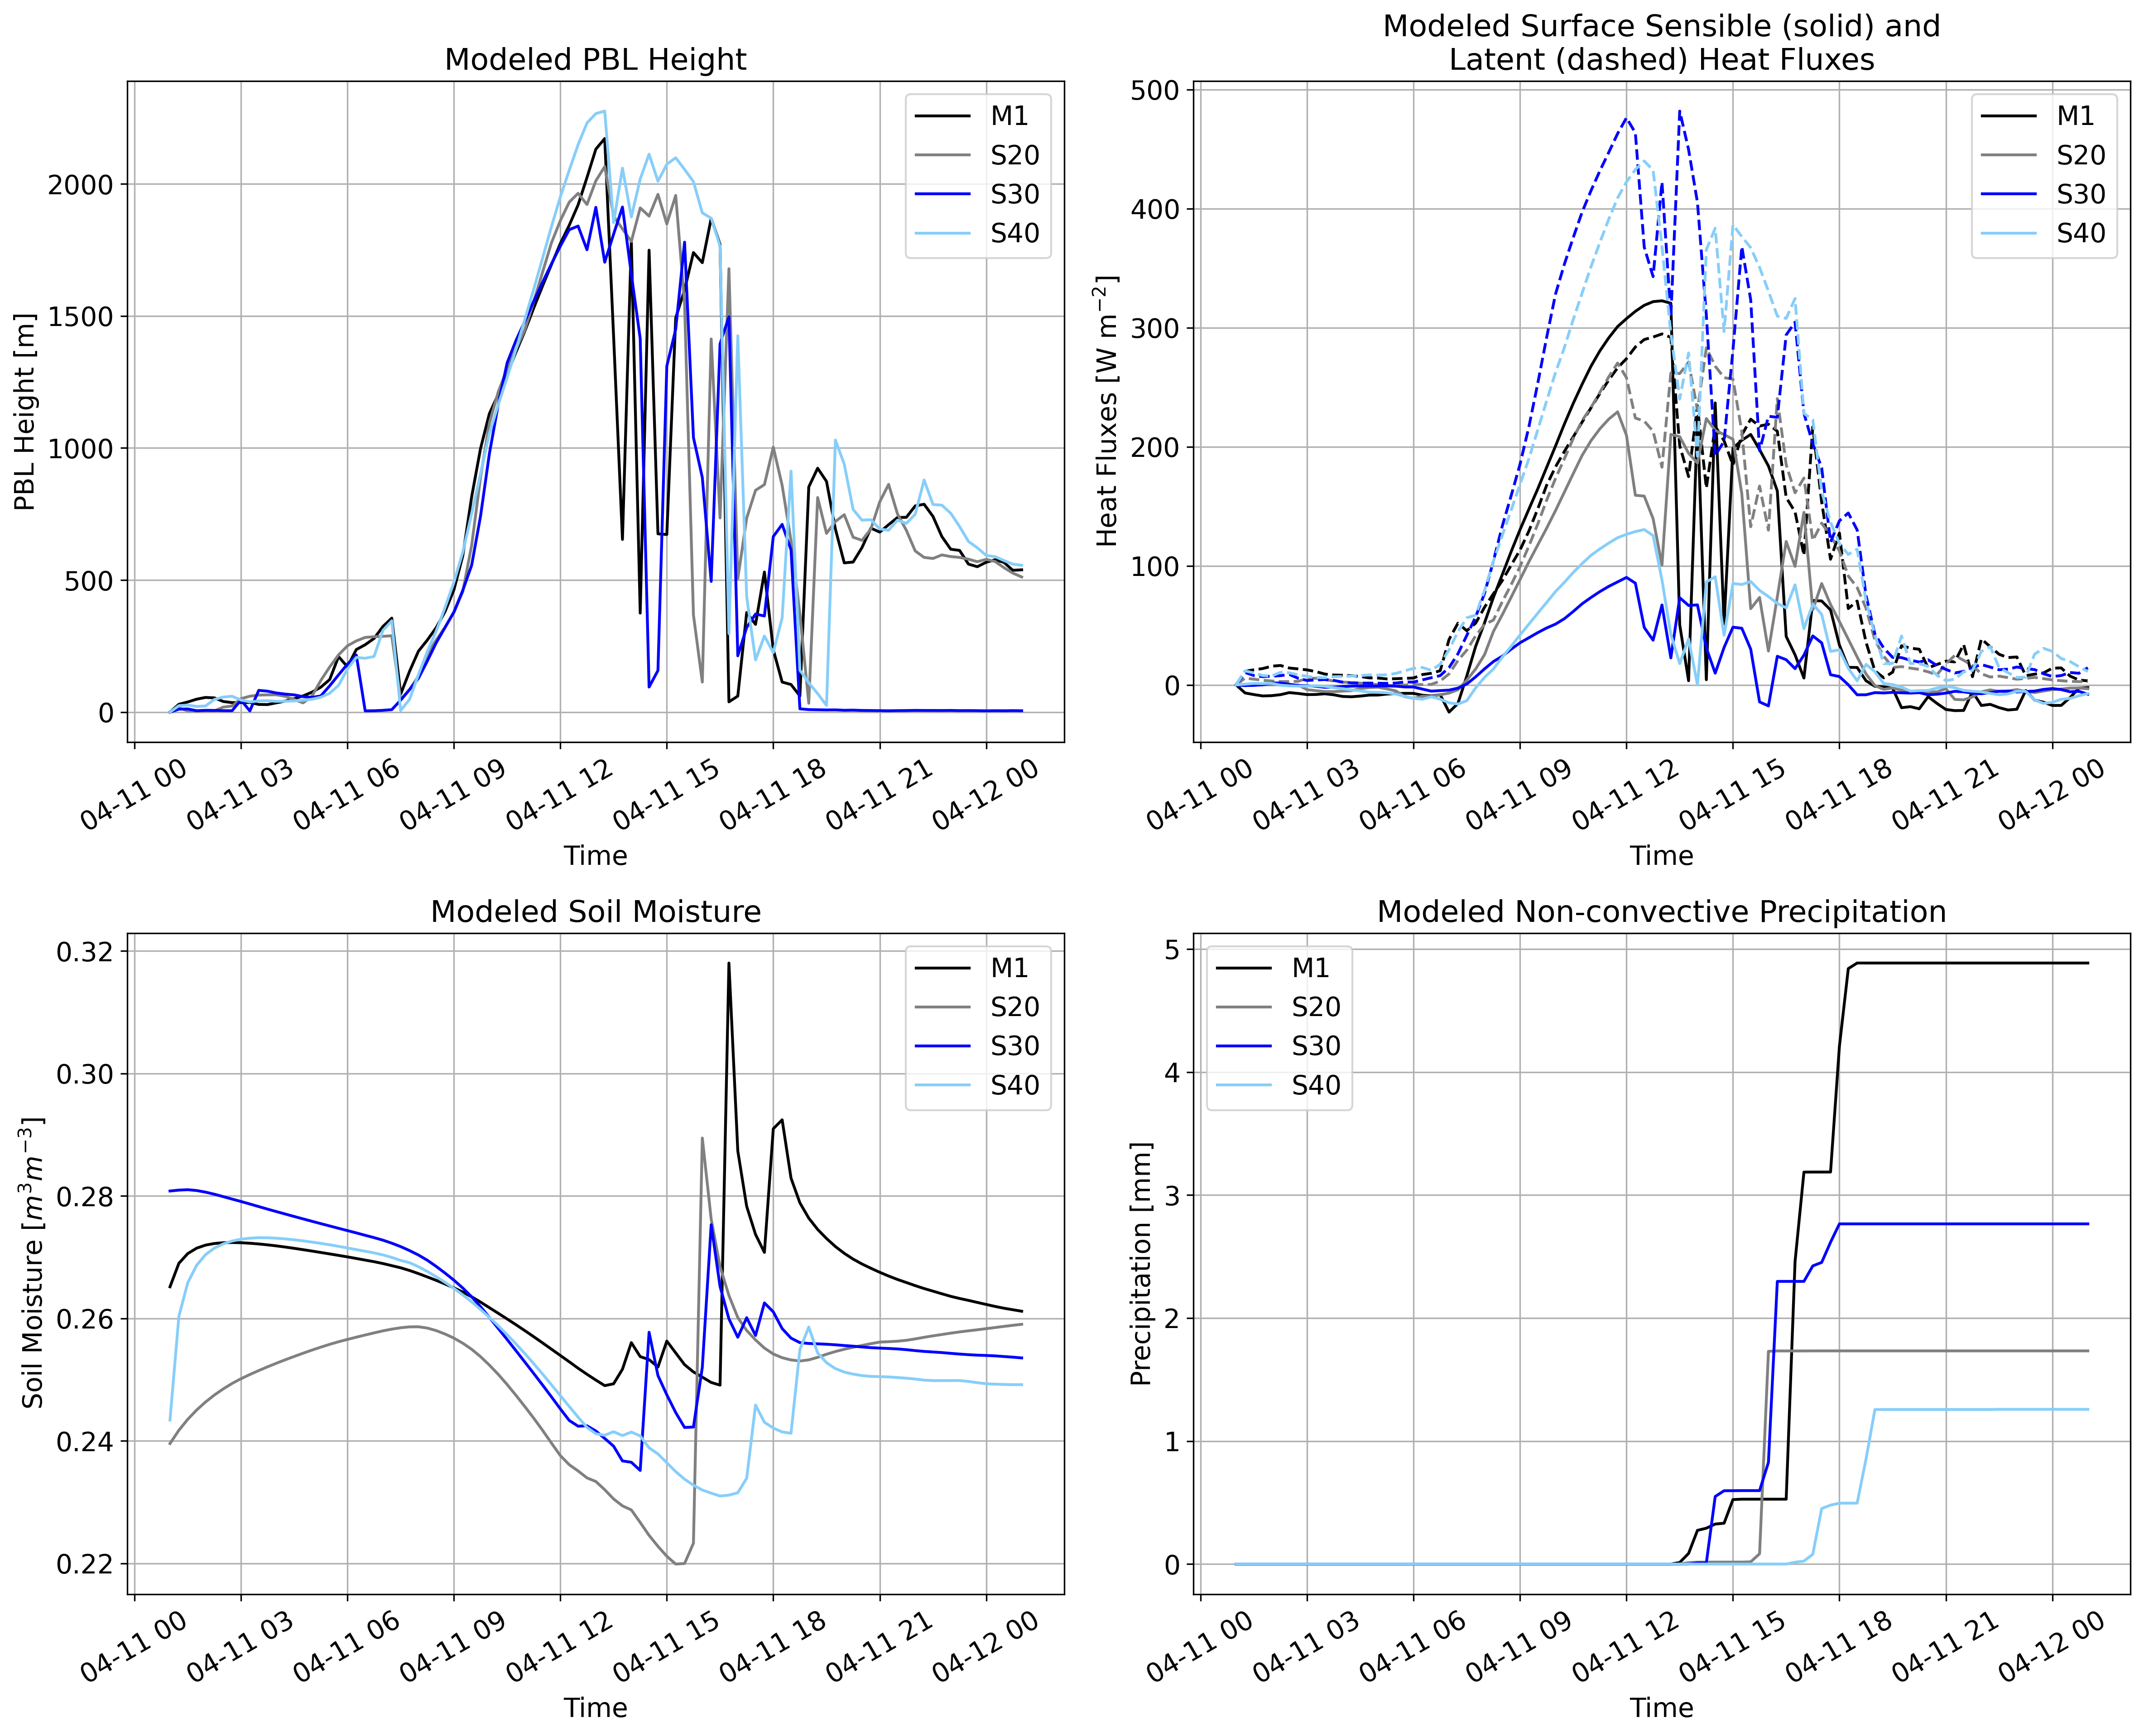

In [8]:
# Set paths to model outputs
path_head = '/data/project/ARM_Summer_School_2025/model/wrf/'
case_days = ['2025041106/'] #15min; 10min 
for case_day in case_days:
    ds_wrf = xr.open_mfdataset(os.path.join(path_head+case_day+'run/wrfout_d01*'),concat_dim='Time',combine='nested')
    # ds_wrf
    # Create a dictionary for our ARM sites so we can easily find them in the model
    # Pull static lat/lon at first time step
    lat2d = ds_wrf['XLAT'].isel(Time=0)
    lon2d = ds_wrf['XLONG'].isel(Time=0)
    # Flatten and build KDTree
    flat_coords = np.column_stack((lat2d.values.ravel(), lon2d.values.ravel()))
    tree = cKDTree(flat_coords)
    # ARM site locations
    target_lat = [34.3425, 34.6538, 34.3848, 34.1788]
    target_lon = [-87.3382, -87.2927, -86.9279, -87.4539]
    target_coords = np.column_stack((target_lat, target_lon))
    # Find nearest indices
    _, flat_idx = tree.query(target_coords)
    i_indices, j_indices = np.unravel_index(flat_idx, lat2d.shape)
    # Create dict of site names to datasets
    site_names = ['M1', 'S20', 'S30', 'S40']
    site_datasets = {}
    for name, i, j in zip(site_names, i_indices, j_indices):
        site_datasets[name] = ds_wrf.isel(south_north=i, west_east=j).expand_dims(site=[name])
    # Subset the original WRF dataset so that it includes information for just our sites
    ds_wrf_bnf_site = xr.concat(site_datasets.values(), dim='site')
    ds_wrf_bnf_site

    var1 = ds_wrf_bnf_site['PBLH']
    var1a = ds_wrf_bnf_site['HFX'] # surface sensible heat flux
    var1b = ds_wrf_bnf_site['LH'] # surface latent heat flux
    var1c = ds_wrf_bnf_site['LWP'] # liquid water path
    LU_INDEX  = ds_wrf_bnf_site['LU_INDEX']
    VEGFRA = ds_wrf_bnf_site['VEGFRA']
    PCT_PFT = ds_wrf_bnf_site['PCT_PFT']
    LAI = ds_wrf_bnf_site['LAI']
    EMISS = ds_wrf_bnf_site['EMISS']
    ALBEDO = ds_wrf_bnf_site['ALBEDO']
    SMOIS = ds_wrf_bnf_site['SMOIS']
    RAINC = ds_wrf_bnf_site['RAINC']
    RAINNC = ds_wrf_bnf_site['RAINNC']
    xtime = pd.to_datetime(var1['XTIME'].values) - pd.Timedelta(hours=5)

    # Make the plot
    plt.figure(figsize=(16, 13),dpi=300)
    cols = ['k','gray','b','lightskyblue']
    ######################## Subplot 1 ########################
    # Sensible and latent heat fluxes
    plt.subplot(2,2,1)
    count = 0
    for site in var1.site.values:
        plt.plot(xtime, var1.sel(site=site), c=cols[count], label=site)
        count+=1
    plt.xticks(rotation=30)
    plt.xlabel("Time")
    plt.ylabel("PBL Height [m]")
    plt.title("Modeled PBL Height")
    plt.legend()
    plt.grid(True)
    #plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    #plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=2))
    ######################## Subplot 2 ########################
    plt.subplot(2,2,2)
    count = 0
    for site in var1a.site.values:
        plt.plot(xtime, var1a.sel(site=site), c=cols[count], label=site)
        plt.plot(xtime, var1b.sel(site=site), c=cols[count], ls='--')
        count+=1
    plt.xticks(rotation=30)
    plt.xlabel("Time")
    plt.ylabel("Heat Fluxes [W m$^{-2}$]")
    plt.title("Modeled Surface Sensible (solid) and\nLatent (dashed) Heat Fluxes")
    plt.legend()
    plt.grid(True)
    ######################## Subplot 3 ########################
    # Sensible and latent heat fluxes
    plt.subplot(2,2,3)
    count = 0
    for site in var1.site.values:
        plt.plot(xtime, SMOIS.sel(site=site)[:,0], c=cols[count], label=site)
        count+=1
    plt.xticks(rotation=30)
    plt.xlabel("Time")
    plt.ylabel("Soil Moisture [$m^3 m^{-3}$]")
    plt.title("Modeled Soil Moisture")
    plt.legend()
    plt.grid(True)

    # Liquid water path
    plt.subplot(2,2,4)
    count = 0
    for site in var1.site.values:
        #plt.plot(var2['XTIME'], var2.sel(site=site), c=cols[count], label=site)
        plt.plot(xtime, RAINNC.sel(site=site), c=cols[count], label=site)
        count+=1
    plt.xticks(rotation=30)
    plt.xlabel("Time")
    #plt.ylabel("Liquid Water Path [kg m$^{-2}$]")
    #plt.title("Modeled Liquid Water Path (solid) at ARM Sites")
    plt.ylabel("Precipitation [mm]")
    plt.title("Modeled Non-convective Precipitation")
    plt.legend()
    plt.grid(True)
    #plt.gcf().autofmt_xdate() # clean up labels
    plt.tight_layout()
    plt.show()